# Load and plot/compare Kjellstrom (LCHCC) and Foster ('Laboratory') work lost maps showing
# per capita and population-weighted losses 1981-2000 and 2001-2020


## First define which variable, paths to data, saving paths

In [1]:
DATAPATH   =   '/Users/lukeaparsons/Documents/Manuscripts/Foster/data/'
FIGUREPATH =  '/Users/lukeaparsons/Documents/Manuscripts/Foster/scripts/Figures/'

## Import modules


In [2]:

import warnings
warnings.filterwarnings('ignore')
import os
import glob
import re
import numpy as np
import xarray as xr
import xesmf as xe
from scipy import stats
from scipy import signal
import time
import pandas as pd
import seaborn as sns
import csv

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
from cartopy.util import add_cyclic_point
%matplotlib inline
import cartopy.util as cutil
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
from mpl_toolkits.basemap import Basemap, maskoceans
import matplotlib.cm as cm
import matplotlib.colors as colors


# set loading parameters here:
### Global warming factor- 0 for present- and n=2 for heavy labor (for Kjellstrom/LCHCC method)
### pattern for warming patterns (even for gwf=0 which is no warming pattern))


In [3]:
local_var = 'swbgt'

erfs = ['Kjellstrom', 'Foster']

timeperiods = ['earlier','later']

gwf = 0

gwfs = [gwf] #gwfs = [0, 1, 2] if looking at future warming impacts, not here

#pattern = 'MonthlyPatterns' #if using future warming patterns from CMIP6 models, not here

#these were the inputs for the labor loss:
# three types of labor (light, medium, heavy):
LaborTypes = ['light','medium','heavy']
n = 2 #n=2 for heavy for Kjellstrom

#define which years to load, average
yearmin = 1981
yearmax = 2020

years = dict()
h = 0
for x in range(yearmin,yearmax+1):
    #print(x)
    years[h] = x
    h = h + 1
print(years) 

years_earlier = dict()
h = 0
for x in range(1981,2000+1):
    #print(x)
    years_earlier[h] = x
    h = h + 1
print(years_earlier) 

years_later = dict()
h = 0
for x in range(2001,2020+1):
    #print(x)
    years_later[h] = x
    h = h + 1
print(years_later) 

{0: 1981, 1: 1982, 2: 1983, 3: 1984, 4: 1985, 5: 1986, 6: 1987, 7: 1988, 8: 1989, 9: 1990, 10: 1991, 11: 1992, 12: 1993, 13: 1994, 14: 1995, 15: 1996, 16: 1997, 17: 1998, 18: 1999, 19: 2000, 20: 2001, 21: 2002, 22: 2003, 23: 2004, 24: 2005, 25: 2006, 26: 2007, 27: 2008, 28: 2009, 29: 2010, 30: 2011, 31: 2012, 32: 2013, 33: 2014, 34: 2015, 35: 2016, 36: 2017, 37: 2018, 38: 2019, 39: 2020}
{0: 1981, 1: 1982, 2: 1983, 3: 1984, 4: 1985, 5: 1986, 6: 1987, 7: 1988, 8: 1989, 9: 1990, 10: 1991, 11: 1992, 12: 1993, 13: 1994, 14: 1995, 15: 1996, 16: 1997, 17: 1998, 18: 1999, 19: 2000}
{0: 2001, 1: 2002, 2: 2003, 3: 2004, 4: 2005, 5: 2006, 6: 2007, 7: 2008, 8: 2009, 9: 2010, 10: 2011, 11: 2012, 12: 2013, 13: 2014, 14: 2015, 15: 2016, 16: 2017, 17: 2018, 18: 2019, 19: 2020}


## Load era5 climatological mean sWBGT, etopo elevation data, regrid to humid heat variable era5 grid for masking oceans


In [4]:
#load era5 grid swbgt data
name_nc = 'swbgt_climatology_era5_Amon_2001_2020.nc'
nc_clim = xr.open_dataset(DATAPATH + str(name_nc))
LAT = nc_clim['lat']
LON = nc_clim['lon']

#load etopo elevation data
nc = xr.open_dataset(DATAPATH + 'etopo20.cdf')
nc = nc.rename({'ETOPO20X1_1081': 'lon','ETOPO20Y': 'lat',}) #rename x to lon, y to lat
elev = nc['ROSE'][:,:]

#regrid elevation data to common lat lon grid used for model data
regridder = xe.Regridder(elev, nc_clim['swbgt_min_LTM'], 'bilinear')
elev_regridded = regridder(elev)#regrid!
#elev_regridded = utils.regriddata(elev,ds_out)
nlat,nlon = elev_regridded.shape
mask = elev_regridded.where(elev_regridded>-50,0)
mask = mask.where(mask<=0,1)
mask = mask.where(mask==1)
mask = mask.values
print('Done regridding etopo data:',nlat,nlon)

Done regridding etopo data: 721 1440


## load the hours lost: climatological mean, and individual years

In [6]:
#individual years
for erf in erfs:
    vars()[str(erf)+'_hourslost_annual'] = xr.open_dataset(DATAPATH + 'laborlost_'+str(erf)+'_percapita_annual_hours_lost_12hrworkday_1981_2020_era5_grid.nc')
    vars()[str(erf)+'_laborlost_annual'] = xr.open_dataset(DATAPATH + 'laborlost_'+str(erf)+'_populationweighted_annual_hours_lost_12hrworkday_1981_2020_grid_05x05.nc')
    vars()[str(erf)+'_prodlost_annual'] = xr.open_dataset(DATAPATH + 'econproductivitylost_'+str(erf)+'_popweight_12hrworkday_1981_2020_grid_05x05.nc')
    
#20-year mean (long-term mean, or LTM)
vars()['hourslost_annual_LTM'] = xr.open_dataset(DATAPATH + 'laborlost_Foster_Kjellstrom_percapita_annual_hours_lost_12hrworkday_1981_2000mean_2001_2020mean_era5_grid.nc')
vars()['laborlost_annual_LTM'] = xr.open_dataset(DATAPATH + 'laborlost_Foster_Kjellstrom_populationweighted_annual_hours_lost_12hrworkday_1981_2000mean_2001_2020mean_grid_05x05.nc')
vars()['prodlost_annual_LTM'] = xr.open_dataset(DATAPATH + 'econproductivitylost_Foster_Kjellstrom_popweight_12hrworkday_1981_2000mean_2001_2020mean_grid_05x05.nc')
    

## 0.5x0.5 country and population grid - use for plotting, and defining sizes of empty arrays below
LAT_countries = vars()[str(erf)+'_laborlost_annual']['lat']
LON_countries = vars()[str(erf)+'_laborlost_annual']['lat']

## for each erf and time period, and year, calculate global and zonal hours lost

In [9]:

for erf in erfs:
    
    for gwf in gwfs: #note just one gwf here- just present (gwf of zero)
        
            for timeperiod in timeperiods:

                #for ILO labor * climate (on country grid)
                vars()['Global_Annual_ILO_Sum_HoursLost_'+str(erf)+'_gwf_'+str(gwf)+'_'+str(timeperiod)] = np.empty([len(vars()['years_'+str(timeperiod)])])
                vars()['Global_Annual_WB_Sum_AgConstrGDPLost2017PPP_'+str(erf)+'_gwf_'+str(gwf)+'_'+str(timeperiod)] = np.empty([len(vars()['years_'+str(timeperiod)])])

                vars()['ZonalSum_Annual_ILO_Sum_HoursLost_'+str(erf)+'_gwf_'+str(gwf)+'_'+str(timeperiod)] = np.empty([len(LAT_countries),len(vars()['years_'+str(timeperiod)])])
                #for background climate heavy labor (on era5 grid)
                vars()['ZonalMedian_Annual_HoursLost_'+str(erf)+'_gwf_'+str(gwf)+'_'+str(timeperiod)] = np.empty([len(LAT),len(vars()['years_'+str(timeperiod)])])


                for yy,year in vars()['years_'+str(timeperiod)].items(): 

                    vars()['Global_Annual_ILO_Sum_HoursLost_'+str(erf)+'_gwf_'+str(gwf)+'_'+str(timeperiod)][yy] = vars()[str(erf)+'_laborlost_annual']['__xarray_dataarray_variable__'].sel(year=str(vars()['years_'+str(timeperiod)][yy])).sum(dim=('lat','lon'))
                    ## Next two lines are already in hourly, so only multiply by 4
                    vars()['Global_Annual_WB_Sum_AgConstrGDPLost2017PPP_'+str(erf)+'_gwf_'+str(gwf)+'_'+str(timeperiod)][yy] = vars()[str(erf)+'_prodlost_annual']['__xarray_dataarray_variable__'].sel(year=str(vars()['years_'+str(timeperiod)][yy])).sum(dim=('lat','lon'))

                    vars()['ZonalSum_Annual_ILO_Sum_HoursLost_'+str(erf)+'_gwf_'+str(gwf)+'_'+str(timeperiod)][:,yy] = vars()[str(erf)+'_laborlost_annual']['__xarray_dataarray_variable__'].sel(year=str(vars()['years_'+str(timeperiod)][yy])).sum(dim='lon')

                    ##Now also for the background hours lost (no ILO)
                    vars()['ZonalMedian_Annual_HoursLost_'+str(erf)+'_gwf_'+str(gwf)+'_'+str(timeperiod)][:,yy] = np.nanmedian(vars()[str(erf)+'_hourslost_annual']['__xarray_dataarray_variable__'].sel(year=str(vars()['years_'+str(timeperiod)][yy])).where(mask>0).squeeze().values,axis=1)

            

## plot Figure 2a and Figure 2b: maps of per capita hours lost

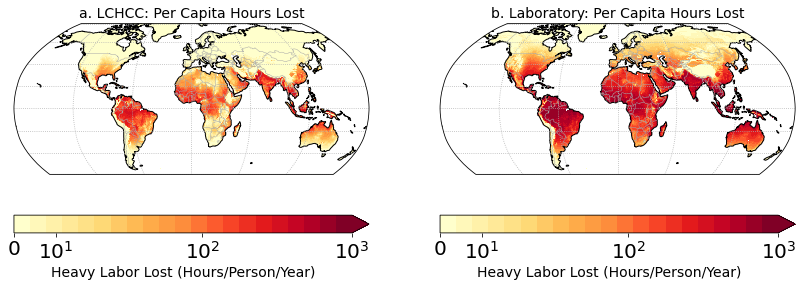

In [20]:

#plt.rcParams["font.family"] = 'TeX Gyre Heros'

fig = plt.figure(figsize=(14,5))

a = 1
b = 2

extent = [-179.99, 179.99, -60, 80]

ax = plt.subplot(a,b,1,projection = ccrs.Robinson(central_longitude=0))
ax.set_global()
ax.coastlines(resolution='110m', linewidth=1)
ax.set_extent(extent)
ax.gridlines(linestyle=':')
ax.add_feature(cartopy.feature.BORDERS,linewidth=0.5,color='darkgrey')
plotvalue = vars()['hourslost_annual_LTM']['annual_hours_lost_Kjellstrom_12hrworkday_2001_2020']
plotvalue = plotvalue * mask
#im = plt.pcolormesh(LON,LAT,plotvalue,cmap=plt.cm.get_cmap('RdBu_r'),transform=ccrs.PlateCarree())
im = plt.pcolormesh(LON,LAT,plotvalue,
            cmap=plt.cm.get_cmap('YlOrRd',21),
            norm=colors.SymLogNorm(linthresh=20, linscale=.5,vmin=0, vmax=1000,base=10),
            transform=ccrs.PlateCarree())
#plt.clim(0, 700)
plt.title('a. LCHCC: Per Capita Hours Lost',fontsize=14,ha='center')
cbar=plt.colorbar(extend='max',orientation='horizontal',shrink=1) #plot colorbar
cbar.ax.tick_params(labelsize=20)
cbar.set_label('Heavy Labor Lost (Hours/Person/Year)',fontsize=14)
#plt.tight_layout()

ax = plt.subplot(a,b,2,projection = ccrs.Robinson(central_longitude=0))
ax.set_global()
ax.coastlines(resolution='110m', linewidth=1)
ax.set_extent(extent)
ax.gridlines(linestyle=':')
ax.add_feature(cartopy.feature.BORDERS,linewidth=0.5,color='darkgrey')
plotvalue = vars()['hourslost_annual_LTM']['annual_hours_lost_Foster_12hrworkday_2001_2020']
plotvalue = plotvalue * mask
#im = plt.pcolormesh(LON,LAT,plotvalue,cmap=plt.cm.get_cmap('RdBu_r'),transform=ccrs.PlateCarree())
im = plt.pcolormesh(LON,LAT,plotvalue,
            cmap=plt.cm.get_cmap('YlOrRd',21),
            norm=colors.SymLogNorm(linthresh=20, linscale=.5,vmin=0, vmax=1000,base=10),
            transform=ccrs.PlateCarree())
#plt.clim(0, 700)
plt.title('b. Laboratory: Per Capita Hours Lost',fontsize=14,ha='center')
cbar=plt.colorbar(extend='max',orientation='horizontal',shrink=1) #plot colorbar
cbar.ax.tick_params(labelsize=20)
cbar.set_label('Heavy Labor Lost (Hours/Person/Year)',fontsize=14)
#plt.tight_layout()

fig.savefig(FIGUREPATH + 'Figure_2_a_b',dpi=300,bbox_inches='tight')


## plot Figure 2c: zonal per capita hours lost

In [ ]:

timeperiod = 'later'

fig = plt.figure(figsize=(4.8,2.7))

ax = plt.subplot(1,1,1)
zerosline = np.arange(0,600,1)
latmin = -60
latmax = 80
plotvalue_Kjellstrom = (vars()['hourslost_annual_LTM']['annual_hours_lost_Kjellstrom_12hrworkday_2001_2020']) * mask
Zonal_Median_Land_Kjellstrom = np.nanmedian(plotvalue_Kjellstrom,axis=1)
Zonal_Max_Land_Kjellstrom = np.nanmin(plotvalue_Kjellstrom,axis=1)
Zonal_Min_Land_Kjellstrom = np.nanmax(plotvalue_Kjellstrom,axis=1)
plotvalue_Kjellstrom_allyears = vars()['Kjellstrom_hourslost_annual']['__xarray_dataarray_variable__'].sel(year=slice("2001-01-01", "2020-12-31")) * mask
Zonal_Median_Land_Kjellstrom_allyears = (plotvalue_Kjellstrom_allyears).median(dim='lon')
Zonal_Max_Land_Kjellstrom_allyears = Zonal_Median_Land_Kjellstrom_allyears.max(dim='year')
Zonal_Min_Land_Kjellstrom_allyears = Zonal_Median_Land_Kjellstrom_allyears.min(dim='year')

plotvalue_Foster = (vars()['hourslost_annual_LTM']['annual_hours_lost_Foster_12hrworkday_2001_2020']) * mask
Zonal_Median_Land_Foster = np.nanmedian(plotvalue_Foster,axis=1)
Zonal_Max_Land_Foster = np.nanmax(plotvalue_Foster,axis=1)
Zonal_Min_Land_Foster = np.nanmin(plotvalue_Foster,axis=1)
plotvalue_Foster_allyears = vars()['Foster_hourslost_annual']['__xarray_dataarray_variable__'].sel(year=slice("2001-01-01", "2020-12-31")) * mask
Zonal_Median_Land_Foster_allyears = (plotvalue_Foster_allyears).median(dim='lon')
Zonal_Max_Land_Foster_allyears = Zonal_Median_Land_Foster_allyears.max(dim='year')
Zonal_Min_Land_Foster_allyears = Zonal_Median_Land_Foster_allyears.min(dim='year')

plt.fill_betweenx(LAT,Zonal_Max_Land_Kjellstrom_allyears,Zonal_Min_Land_Kjellstrom_allyears,
                  #np.nanmin(vars()['ZonalMedian_Annual_HoursLost_Kjellstrom_gwf_'+str(gwf)+'_'+str(timeperiod)],axis=1),
                  #np.nanmax(vars()['ZonalMedian_Annual_HoursLost_Kjellstrom_gwf_'+str(gwf)+'_'+str(timeperiod)],axis=1),
                  color = 'darkblue', alpha=0.5)
plt.plot(Zonal_Median_Land_Kjellstrom,LAT,linewidth=2,color='darkblue',label='LCHCC')    

#plt.plot(Zonal_Median_Land_Foster,LAT,linewidth=3,color='darkred',label='Foster')
plt.fill_betweenx(LAT,Zonal_Max_Land_Foster_allyears,Zonal_Min_Land_Foster_allyears,
                  #np.nanmin(vars()['ZonalMedian_Annual_HoursLost_Foster_gwf_'+str(gwf)+'_'+str(timeperiod)],axis=1),
                  #np.nanmax(vars()['ZonalMedian_Annual_HoursLost_Foster_gwf_'+str(gwf)+'_'+str(timeperiod)],axis=1),
                  color = 'darkred', alpha=0.5)
plt.plot(Zonal_Median_Land_Foster,LAT,linewidth=2,color='darkred',label='Laboratory')

plt.plot(zerosline,np.zeros(np.shape(zerosline)),linewidth=3,color='k',linestyle=':')
plt.grid('True')
plt.xlabel('Heavy Labor Lost (Hours/Person/Year)',fontsize=14)
#plt.xticks(np.arange(0,2.5,.5),fontsize=16)
plt.xlim(0, 650)
plt.ylim(latmin, latmax)
plt.ylabel('Latitude ($^o$N)',fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
plt.legend(fontsize=14)
plt.title('c. Zonal Median: Per Capita Losses',fontsize=14,ha='center')
#plt.tight_layout()

fig.savefig(FIGUREPATH + 'Figure_2_c',dpi=300,bbox_inches='tight')


## plot Figure 2d and Figure 2e: maps of outdoor working age population * per capita hours lost

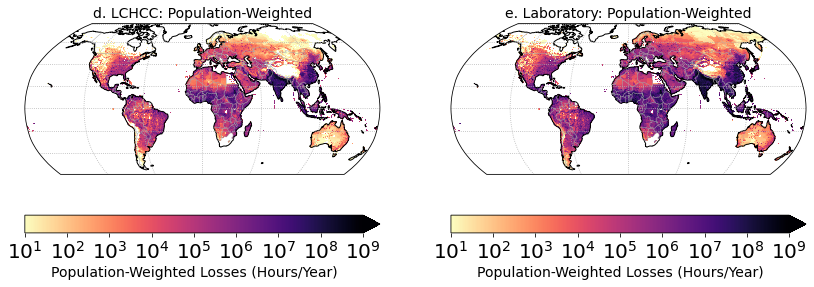

In [25]:
import cartopy.feature as cfeature

fig = plt.figure(figsize=(14,5))
a = 1
b = 2

extent = [-179.99, 179.99, -60, 80]
#variable = 'minutes_maxmeanhalf'

ax = plt.subplot(a,b,1,projection = ccrs.Robinson(central_longitude=0))
ax.set_global()
ax.coastlines(resolution='110m', linewidth=1)
ax.set_extent(extent)
ax.gridlines(linestyle=':')
ax.add_feature(cartopy.feature.BORDERS,linewidth=0.5,color='darkgrey')
plotvalue = (vars()['laborlost_annual_LTM']['annual_hours_lost_Kjellstrom_12hrworkday_2001_2020_mean'])
plotvalue = plotvalue.where(plotvalue>1)
im = plt.pcolormesh(vars()['laborlost_annual_LTM']['lon'],vars()['laborlost_annual_LTM']['lat'],plotvalue,
                    cmap=plt.cm.get_cmap('magma_r'),
                    norm=colors.SymLogNorm(linthresh=1, linscale=10,vmin=10, vmax=1e9,base=10),
                    transform=ccrs.PlateCarree())
#plt.clim(0, 1000)
plt.title('d. LCHCC: Population-Weighted',fontsize=14,ha='center')
cbar=plt.colorbar(extend='max',orientation='horizontal',shrink=1) #plot colorbar
cbar.ax.tick_params(labelsize=20)
cbar.set_label('Population-Weighted Losses (Hours/Year)',fontsize=14)

ax = plt.subplot(a,b,2,projection = ccrs.Robinson(central_longitude=0))
ax.set_global()
ax.coastlines(resolution='110m', linewidth=1)
ax.set_extent(extent)
ax.gridlines(linestyle=':')
ax.add_feature(cartopy.feature.BORDERS,linewidth=0.5,color='darkgrey')
plotvalue = (vars()['laborlost_annual_LTM']['annual_hours_lost_Foster_12hrworkday_2001_2020_mean'])
plotvalue = plotvalue.where(plotvalue>1)
im = plt.pcolormesh(vars()['laborlost_annual_LTM']['lon'],vars()['laborlost_annual_LTM']['lat'],plotvalue,
                    cmap=plt.cm.get_cmap('magma_r'),
                    norm=colors.SymLogNorm(linthresh=1, linscale=10,vmin=10, vmax=1e9,base=10),
                    transform=ccrs.PlateCarree())
#plt.clim(0, 1000)
plt.title('e. Laboratory: Population-Weighted',fontsize=14,ha='center')
cbar=plt.colorbar(extend='max',orientation='horizontal',shrink=1) #plot colorbar
cbar.ax.tick_params(labelsize=20)
cbar.set_label('Population-Weighted Losses (Hours/Year)',fontsize=14)

fig.savefig(FIGUREPATH + 'Figure_2_d_e',dpi=300,bbox_inches='tight')


## plot Figure 2f: zonal sum population * per capita hours lost
### note divide by 1e9 to convert to billions of hours lost/year

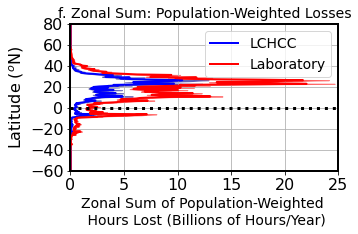

In [58]:
fig = plt.figure(figsize=(4.8,2.7))

ax = plt.subplot(1,1,1)

ax = plt.subplot(1,1,1)
zerosline = np.arange(0,50,1)
latmin = -60
latmax = 80
plotvalue_Kjellstrom = (vars()['laborlost_annual_LTM']['annual_hours_lost_Kjellstrom_12hrworkday_2001_2020_mean'])
Zonal_Sum_Land_Kjellstrom = np.nansum(plotvalue_Kjellstrom,axis=1)
Zonal_Mean_Land_Kjellstrom = np.nanmean(plotvalue_Kjellstrom,axis=1)
Zonal_Max_Land_Kjellstrom = np.nanmax(plotvalue_Kjellstrom,axis=1)
Zonal_Min_Land_Kjellstrom = np.nanmin(plotvalue_Kjellstrom,axis=1)
plotvalue_Kjellstrom_allyears = vars()['Kjellstrom_laborlost_annual']['__xarray_dataarray_variable__'].sel(year=slice("2001-01-01", "2020-12-31"))
Zonal_Median_Land_Kjellstrom_allyears = (plotvalue_Kjellstrom_allyears).sum(dim='lon')
Zonal_Max_Land_Kjellstrom_allyears = Zonal_Median_Land_Kjellstrom_allyears.max(dim='year')
Zonal_Min_Land_Kjellstrom_allyears = Zonal_Median_Land_Kjellstrom_allyears.min(dim='year')


plotvalue_Foster = (vars()['laborlost_annual_LTM']['annual_hours_lost_Foster_12hrworkday_2001_2020_mean'])
Zonal_Sum_Land_Foster = np.nansum(plotvalue_Foster,axis=1)
Zonal_Mean_Land_Foster = np.nanmean(plotvalue_Foster,axis=1)
Zonal_Max_Land_Foster = np.nanmax(plotvalue_Foster,axis=1)
Zonal_Min_Land_Foster = np.nanmin(plotvalue_Foster,axis=1)
plotvalue_Foster_allyears = vars()['Foster_laborlost_annual']['__xarray_dataarray_variable__'].sel(year=slice("2001-01-01", "2020-12-31"))
Zonal_Median_Land_Foster_allyears = (plotvalue_Foster_allyears).sum(dim='lon')
Zonal_Max_Land_Foster_allyears = Zonal_Median_Land_Foster_allyears.max(dim='year')
Zonal_Min_Land_Foster_allyears = Zonal_Median_Land_Foster_allyears.min(dim='year')



plt.fill_betweenx(vars()['laborlost_annual_LTM']['lat'],Zonal_Max_Land_Kjellstrom_allyears/1e9,Zonal_Min_Land_Kjellstrom_allyears/1e9,
                  color = 'darkblue', alpha=0.5)

plt.plot(Zonal_Sum_Land_Kjellstrom/1e9,vars()['laborlost_annual_LTM']['lat'],linewidth=2,color='blue',label='LCHCC')    

plt.fill_betweenx(vars()['laborlost_annual_LTM']['lat'],Zonal_Max_Land_Foster_allyears/1e9,Zonal_Min_Land_Foster_allyears/1e9,
                  color = 'red', alpha=0.5)

plt.plot(Zonal_Sum_Land_Foster/1e9,vars()['laborlost_annual_LTM']['lat'],linewidth=2,color='red',label='Laboratory')

plt.plot(zerosline,np.zeros(np.shape(zerosline)),linewidth=3,color='k',linestyle=':')
plt.grid('True')
plt.xlabel('Zonal Sum of Population-Weighted \n Hours Lost (Billions of Hours/Year)',fontsize=14)
#plt.xticks(np.arange(0,2.5,.5),fontsize=16)
plt.xlim(0, 25)
plt.ylim(latmin, latmax)
plt.ylabel('Latitude ($^o$N)',fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
plt.legend(fontsize=14)
plt.title('f. Zonal Sum: Population-Weighted Losses',fontsize=14,ha='center')
#plt.tight_layout()

fig.savefig(FIGUREPATH + 'Figure_2_f',dpi=300,bbox_inches='tight')


## Figure 3a and Figure 3b: delta (change) in hours lost 1981-2000 vs 2001-2020

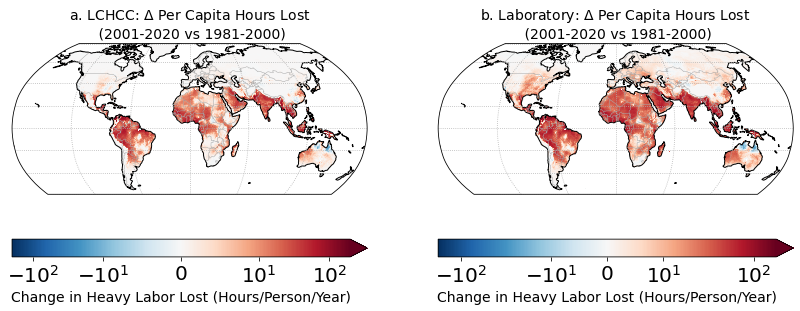

In [18]:

#plt.rcParams["font.family"] = 'TeX Gyre Heros'

fig = plt.figure(figsize=(14,5.5))

a = 1
b = 2

extent = [-179.99, 179.99, -60, 80]

##now DIFFERNCE
ax = plt.subplot(a,b,1,projection = ccrs.Robinson(central_longitude=0))
ax.set_global()
ax.coastlines(resolution='110m', linewidth=1)
ax.set_extent(extent)
ax.gridlines(linestyle=':')
ax.add_feature(cartopy.feature.BORDERS,linewidth=0.5,color='darkgrey')
plotvalue = (vars()['hourslost_annual_LTM']['annual_hours_lost_Kjellstrom_12hrworkday_2001_2020'] - vars()['hourslost_annual_LTM']['annual_hours_lost_Kjellstrom_12hrworkday_1981_2000'])
plotvalue = plotvalue * mask
#im = plt.pcolormesh(LON,LAT,plotvalue,cmap=plt.cm.get_cmap('RdBu_r'),transform=ccrs.PlateCarree())
im = plt.pcolormesh(LON,LAT,plotvalue,
            cmap=plt.cm.get_cmap('RdBu_r'),
            norm=colors.SymLogNorm(linthresh=10, linscale=1,vmin=-200, vmax=200,base=10),
            transform=ccrs.PlateCarree())
#plt.clim(0, 700)
plt.title('a. LCHCC: $\Delta$ Per Capita Hours Lost \n (2001-2020 vs 1981-2000)',fontsize=14,ha='center')
cbar=plt.colorbar(extend='max',orientation='horizontal',shrink=1) #plot colorbar
cbar.ax.tick_params(labelsize=20)
cbar.set_label('Change in Heavy Labor Lost (Hours/Person/Year)',fontsize=14)
#plt.tight_layout()

ax = plt.subplot(a,b,2,projection = ccrs.Robinson(central_longitude=0))
ax.set_global()
ax.coastlines(resolution='110m', linewidth=1)
ax.set_extent(extent)
ax.gridlines(linestyle=':')
ax.add_feature(cartopy.feature.BORDERS,linewidth=0.5,color='darkgrey')
plotvalue = (vars()['hourslost_annual_LTM']['annual_hours_lost_Foster_12hrworkday_2001_2020'] - vars()['hourslost_annual_LTM']['annual_hours_lost_Foster_12hrworkday_1981_2000'])
plotvalue = plotvalue * mask
#im = plt.pcolormesh(LON,LAT,plotvalue,cmap=plt.cm.get_cmap('RdBu_r'),transform=ccrs.PlateCarree())
im = plt.pcolormesh(LON,LAT,plotvalue,
            cmap=plt.cm.get_cmap('RdBu_r'),
            norm=colors.SymLogNorm(linthresh=15, linscale=1,vmin=-200, vmax=200,base=10),
            transform=ccrs.PlateCarree())
#plt.clim(0, 700)
plt.title('b. Laboratory: $\Delta$ Per Capita Hours Lost \n (2001-2020 vs 1981-2000)',fontsize=14,ha='center')
cbar=plt.colorbar(extend='max',orientation='horizontal',shrink=1) #plot colorbar
cbar.ax.tick_params(labelsize=20)
cbar.set_label('Change in Heavy Labor Lost (Hours/Person/Year)',fontsize=14)
#plt.tight_layout()

fig.savefig(FIGUREPATH + 'Figure_3_a_b',dpi=300,bbox_inches='tight')


## Figure 3c: Zonal change in hours lost between two time periods

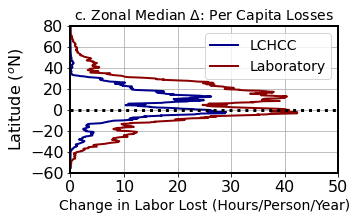

In [16]:

fig = plt.figure(figsize=(4.8,2.7))

ax = plt.subplot(1,1,1)
zerosline = np.arange(0,600,1)
latmin = -60
latmax = 80
plotvalue_Kjellstrom = (vars()['hourslost_annual_LTM']['annual_hours_lost_Kjellstrom_12hrworkday_2001_2020'] - 
                        vars()['hourslost_annual_LTM']['annual_hours_lost_Kjellstrom_12hrworkday_1981_2000']) * mask
Zonal_Median_Land_Kjellstrom = np.nanmedian(plotvalue_Kjellstrom,axis=1)
Zonal_Max_Land_Kjellstrom = np.nanmax(plotvalue_Kjellstrom,axis=1)
Zonal_Min_Land_Kjellstrom = np.nanmin(plotvalue_Kjellstrom,axis=1)

plotvalue_Foster =  (vars()['hourslost_annual_LTM']['annual_hours_lost_Foster_12hrworkday_2001_2020'] - 
                        vars()['hourslost_annual_LTM']['annual_hours_lost_Foster_12hrworkday_1981_2000']) * mask
Zonal_Median_Land_Foster = np.nanmedian(plotvalue_Foster,axis=1)
Zonal_Max_Land_Foster = np.nanmax(plotvalue_Foster,axis=1)
Zonal_Min_Land_Foster = np.nanmin(plotvalue_Foster,axis=1)

plt.plot(Zonal_Median_Land_Kjellstrom,LAT,linewidth=2,color='darkblue',label='LCHCC')    

plt.plot(Zonal_Median_Land_Foster,LAT,linewidth=2,color='darkred',label='Laboratory')

plt.plot(zerosline,np.zeros(np.shape(zerosline)),linewidth=3,color='k',linestyle=':')
plt.grid('True')
plt.xlabel('Change in Labor Lost (Hours/Person/Year)',fontsize=14)
#plt.xticks(np.arange(0,2.5,.5),fontsize=16)
plt.xlim(0, 50)
plt.ylim(latmin, latmax)
plt.ylabel('Latitude ($^o$N)',fontsize=16)
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
plt.legend(fontsize=14)
#plt.title('i. Zonal Median $\Delta$: Per Capita Losses',fontsize=14,ha='center')
plt.title('c. Zonal Median $\Delta$: Per Capita Losses',fontsize=14,ha='center')

#plt.tight_layout()

fig.savefig(FIGUREPATH + 'Figure_3_c',dpi=300,bbox_inches='tight')
